# Assignment 2

In [343]:
!pip3 install python3-wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [344]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random
from time import time

from data_rnn import load_ndfa, load_brackets

In [345]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.distributions as dist

In [346]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

device

device(type='cuda')

### Load data

In [347]:
# # NDFA
# x_train, (i2w, w2i) = load_brackets(n=150_000)

# Brackets
x_train, (i2w, w2i) = load_brackets(n=150_000)

In [348]:
len(x_train)

150000

In [349]:
x_train[0]

[5, 4]

In [350]:
def print_sequence(seq):
    if seq[0] == w2i['.start']:
        seq = seq[1:]
    if seq[-1] == w2i['.end']:
        seq = seq[:-1]
        
    print(''.join([i2w[i] for i in seq]) )


In [351]:
print_sequence(x_train[120_600])

((()()))


In [352]:
vocab_size = len(w2i)
vocab_size

6

In [353]:
w2i

{'.pad': 0, '.start': 1, '.end': 2, '.unk': 3, ')': 4, '(': 5}

In [354]:
def get_max_seq_length(batch):
    return max(len(seq) for seq in batch)

In [355]:
def get_sum_seq_lengths(batch):
    return sum(len(seq) for seq in batch)

In [356]:
def add_padding(seq, amt=1):
    for _ in range(amt):
        seq.append(w2i['.pad'])
    return seq

In [357]:
def add_start(seq):
    seq.insert(0, w2i['.start'])
    return seq

In [358]:
def add_end(seq):
    seq.append(w2i['.end'])
    return seq

In [359]:
print(f'The longest sequence in trainset has {get_max_seq_length(x_train)} length.')

The longest sequence in trainset has 1022 length.


In [360]:
print(f'Mean length of a sequence in trainset is {get_sum_seq_lengths(x_train) / len(x_train)}.')

Mean length of a sequence in trainset is 9.01628.


In [361]:
def preprocess_batch(batch):
    max_len = get_max_seq_length(batch)
    
    upd_batch = []
    for i, _ in enumerate(batch):
        seq = batch[i].copy()
        seq = add_start(seq)
        seq = add_end(seq)
        seq = add_padding(seq, amt=max_len + 2 - len(seq))
        upd_batch.append(seq)
    
    upd_batch = torch.tensor(upd_batch, dtype=torch.long)
    return upd_batch

In [362]:
def get_batches(data, max_token_amount=10000):
    batches, targets = [], []
    bound_l, bound_r = -1, 0

    while bound_r < len(data):
        bound_l = bound_r

        num_of_tokens = 0
        while bound_r < len(data) and (num_of_tokens + len(data[bound_r])) < max_token_amount:
            num_of_tokens += len(data[bound_r])
            bound_r += 1
        print(bound_l, bound_r)
        batch = data[bound_l:bound_r]
        batch = preprocess_batch(batch)
        target = F.pad(batch, (0, 1), "constant", 0)[:, 1:]
        # target = F.one_hot(target, num_classes=vocab_size)

        batches.append(batch)
        targets.append(target)
    return batches, targets


In [363]:
def batch_generator(batches, targets):
    indices = list(range(len(batches)))
    random.shuffle(indices)
    # print(f'Shuffle: {indices}')
    
    for ind in indices:
        yield batches[ind], targets[ind], (len(batches[ind]), len(batches[ind][0]))

## Question 5

In [364]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_size=32, hidden_size=16, lstm_num_layers=3) -> None:
        super().__init__()

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, lstm_num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, input):
        x = input
        x = self.embed(x)
        x, (hn, cn) = self.lstm(x)
        output = self.linear(x)
        return output

In [365]:
net = Net(vocab_size)
net

Net(
  (embed): Embedding(6, 32)
  (lstm): LSTM(32, 16, num_layers=3, batch_first=True)
  (linear): Linear(in_features=16, out_features=6, bias=True)
)

In [366]:
def sample(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome logits
    :param temperature: Sampling temperature. 1.0 follows the given
    distribution, 0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """
    if temperature == 0.0:
        return lnprobs.argmax()

    p = F.softmax(lnprobs / temperature, dim=0)
    cd = dist.Categorical(p)
    
    return cd.sample()

In [367]:
def generate_seq(model, w2i, start_seq, max_length=25, temp=1.0, device=torch.device('cpu')):
    new_seq = start_seq.copy()
    start_seq = torch.tensor(start_seq, dtype=torch.long).to(device)
    start_seq = start_seq[None, :]

    output = model(start_seq)
    last_token = sample(output[0, -1, :])

    curr_len = len(start_seq)
    while curr_len < max_length and last_token.item() != w2i['.end']:
        new_seq.append(last_token.item())
        curr_len += 1

        output = model(last_token.reshape(1, 1))
        last_token = sample(output[0, -1, :], temp)
    new_seq.append(last_token)
    
    return new_seq


In [368]:
def train(model, batches, targets, start_seq, epochs=3, learning_rate=0.01, 
    grad_limit=3, max_length=25, temp=1.0, device=torch.device('cpu')):
        
    criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=w2i['.pad'])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    metrics = {
        'loss_history': [], # loss per iteration
        'loss_train': [], # loss per epoch
        'loss_history_per_token': [] # loss per token on iteratiom
    }

    samples = defaultdict(list)

    total_loss = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")

        for i, (x_batch, y_batch, _) in enumerate(batch_generator(batches, targets)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            assert x_batch.shape == y_batch.shape

            optimizer.zero_grad()

            start_time = time()
            outputs = model(x_batch)
            # print(outputs.shape)
            loss = criterion(outputs.reshape(outputs.shape[0]*outputs.shape[1], -1), y_batch.reshape(y_batch.shape[0]*y_batch.shape[1], )) # outputs: [batch_size*time, vocab_size], y:[batch_size*time]
            loss.backward()
            finish_time = time()

            # print statistics
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item() / y_batch.size()[0] / y_batch.size()[-1]:.6f} time: {finish_time - start_time:.3f}')
            metrics['loss_history_per_token'].append(loss.item() / y_batch.size()[0] / y_batch.size()[-1]) # loss per token for each iteration
            metrics['loss_history'].append(loss.item())
            total_loss.append(loss.item())

            nn.utils.clip_grad_norm_(model.parameters(), grad_limit)
            optimizer.step()

        metrics['loss_train'].append(np.mean(total_loss)) # mean loss per epoch

        for _ in range(10):
            samples[epoch].append(generate_seq(model, w2i, start_seq, max_length, temp, device))
            
    return model, metrics, samples

In [369]:
batches, targets = get_batches(x_train, max_token_amount=max_token_amount)
print(len(batches))

0 24999
24999 49998
49998 74997
74997 92323
92323 104822
104822 113338
113338 120164
120164 125505
125505 129703
129703 133086
133086 135875
135875 138200
138200 140137
140137 141784
141784 143176
143176 144358
144358 145368
145368 146234
146234 146978
146978 147621
147621 148174
148174 148644
148644 149042
149042 149374
149374 149642
149642 149853
149853 149995
149995 150000
28


In [370]:
batches[0][:5], targets[0][:5]

(tensor([[1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2]]), tensor([[5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0]]))

In [371]:
start_seq = [
    w2i['.start'], 
    w2i['('], 
    w2i['('], 
    w2i[')']
]

In [372]:
vocab_size=len(w2i)
max_token_amount = 50000


embedding_size = 32
hidden_size = 16
lstm_num_layers = 1

grad_limit = 5
max_length = 25
# temp = 1.0
temp = 0.1

epochs = 20
learning_rate = 0.01

In [373]:
model = Net(vocab_size, embedding_size, hidden_size, lstm_num_layers)
model, metrics, samples = train(model, batches, targets, start_seq, epochs, learning_rate, grad_limit, max_length, temp, device)

Epoch 1
-------------------------------
[1,     1] loss: 1.612132 time: 0.009
[1,     2] loss: 1.241236 time: 0.017
[1,     3] loss: 1.383036 time: 0.009
[1,     4] loss: 0.967198 time: 0.017
[1,     5] loss: 1.248592 time: 0.010
[1,     6] loss: 1.081237 time: 0.017
[1,     7] loss: 1.104800 time: 0.009
[1,     8] loss: 0.968510 time: 0.010
[1,     9] loss: 0.963997 time: 0.011
[1,    10] loss: 0.979239 time: 0.008
[1,    11] loss: 0.913503 time: 0.007
[1,    12] loss: 0.587399 time: 0.010
[1,    13] loss: 0.806929 time: 0.007
[1,    14] loss: 0.795035 time: 0.007
[1,    15] loss: 0.828699 time: 0.010
[1,    16] loss: 0.733769 time: 0.007
[1,    17] loss: 0.672204 time: 0.007
[1,    18] loss: 0.738402 time: 0.007
[1,    19] loss: 1.018094 time: 0.010
[1,    20] loss: 0.492783 time: 0.007
[1,    21] loss: 1.233314 time: 0.013
[1,    22] loss: 0.686737 time: 0.007
[1,    23] loss: 0.891326 time: 0.008
[1,    24] loss: 0.658438 time: 0.007
[1,    25] loss: 0.716098 time: 0.007
[1,    26]

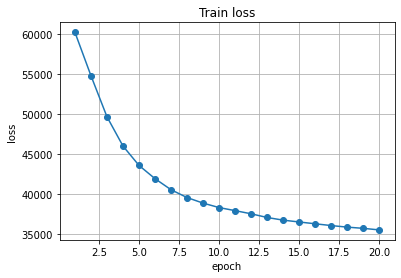

In [374]:
plt.plot(range(1, epochs + 1), metrics['loss_train'], marker='o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

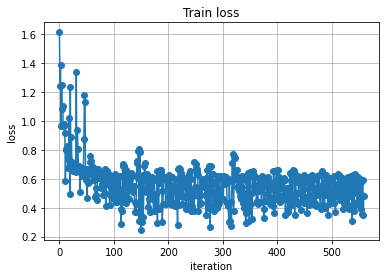

In [375]:
plt.plot(metrics['loss_history_per_token'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

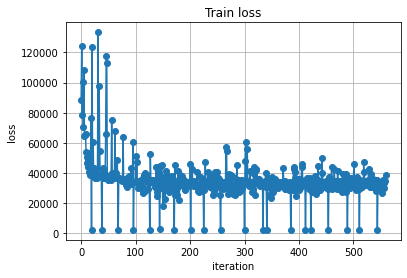

In [376]:
plt.plot(metrics['loss_history'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

In [377]:
for epoch, generated in samples.items():
    print(f'EPOCH {epoch}')
    valid = 0
    for seq in generated:
        print_sequence(seq)
        if seq.count(w2i['(']) == seq.count(w2i[')']):
          valid += 1
    print(f'{valid=}')
    print()

EPOCH 0
(()((((((((((((((((((((()(((
(()(((((()((()((((((((((((((
(()
(())((((((((((((()((()((((((
(())((()(((()((()(((((((((((
(())(((()((((()()))(((((((((
(()((()(((((((((((((((((((((
(()(((((((((((((((((((((((((
(())((((((((())(((((((((((((
(()(((((((((((((((((((((((((
valid=0

EPOCH 1
(()((()
(()()
(())
(()()()(((()
(())
(()(()
(()()
(())()
(()()()()()((()
(())()()
valid=4

EPOCH 2
(()()
(()()
(())
(()()
(()()
(())
(()()
(()()
(()
(())
valid=3

EPOCH 3
(())
(()
(()(()
(()
(())
(())
(())
(()()
(())
(()()
valid=5

EPOCH 4
(()()
(()()
(())
(()()
(()()
(()()
(()()
(()()
(()()
(()()
valid=1

EPOCH 5
(()(((((((((((((((((((((((((
(()(((((((((()
(()(((((((((((((()
(())
(()(((((((((((((((((((((((((
(())
(()(((((((((((((()
(())
(()(((((((((((()
(())
valid=4

EPOCH 6
(()
(())
(()(((((((((((((((((((((()
(()(((((((((((((((((((((((((
(()(((((((((((((((((((((((((
(()(((()
(()(((((((((((((((((((((()
(()((((((()
(())
(()(((((((((((((((((((((((((
valid=2

EPOCH 7
(()()
(()(()
(())
(())
(()(()
(())
(